In [1]:
pip install transformers datasets evaluate kagglehub[pandas-datasets] spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 147.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

save_path = Path("/content/drive/MyDrive/poet_model")
save_path.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [7]:
import kagglehub

dataset_path = kagglehub.dataset_download("tgdivy/poetry-foundation-poems")
dataset_path = Path(dataset_path)
print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/tgdivy/poetry-foundation-poems/versions/1


In [8]:
import pandas as pd
import os

df = pd.read_csv(dataset_path / "PoetryFoundationData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13854 entries, 0 to 13853
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13854 non-null  int64 
 1   Title       13854 non-null  object
 2   Poem        13854 non-null  object
 3   Poet        13854 non-null  object
 4   Tags        12899 non-null  object
dtypes: int64(1), object(4)
memory usage: 541.3+ KB


In [9]:
import re

def normalize(poem: str) -> str:
    poem = re.sub(r"\r\r\n", "\n", poem)
    poem = re.sub(r"\r\n", "\n", poem)
    poem = re.sub(r"\n\s+", "\n", poem)
    poem = re.sub(r" +", " ", poem)
    return poem.strip()

df["Poem"] = df["Poem"].map(normalize)

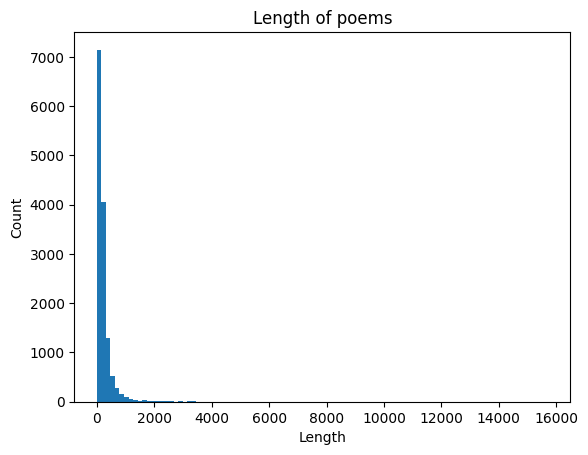

In [ ]:
import matplotlib.pyplot as plt

df["Length"] = df["Poem"].map(lambda poem: len(poem.split()))
plt.hist(df["Length"], bins=100)
plt.title("Length of poems")
plt.ylabel("Count")
plt.xlabel("Length")
plt.show()

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1165 > 1024). Running this sequence through the model will result in indexing errors


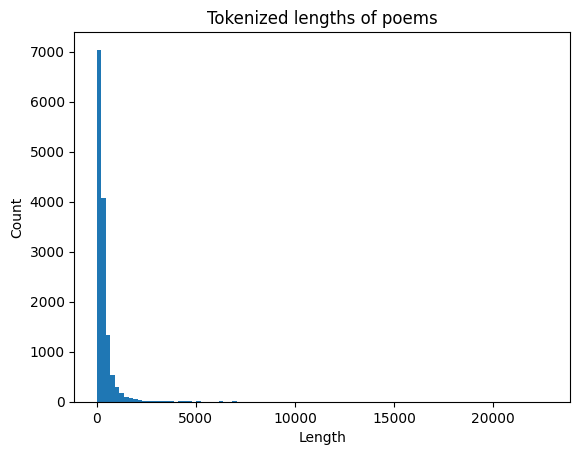

In [ ]:
df["Tokenized Length"] = df["Poem"].map(lambda text: len(tokenizer(start + text).input_ids))
plt.hist(df["Tokenized Length"], bins=100)
plt.title("Tokenized lengths of poems")
plt.ylabel("Count")
plt.xlabel("Length")
plt.show()

In [ ]:
print(f"Before: {len(df)}")

df = df[df["Tokenized Length"] <= 1024].copy()

print(f"After: {len(df)}")

Before: 13854
After: 13139


In [ ]:
import spacy
from tqdm.auto import tqdm

tqdm.pandas()

nlp = spacy.load("en_core_web_sm")

def get_nouns(text: str) -> list[str]:
  doc = nlp(text)
  nouns = set()
  for token in doc:
    if token.pos_ in ["NOUN", "PROPN"]:
      nouns.add(token.text.lower())
  return list(nouns)

df["Nouns"] = df["Poem"].progress_apply(get_nouns)

  0%|          | 0/13139 [00:00<?, ?it/s]

In [ ]:
df = df[df["Poem"].notna()]
df[["Poem", "Tokenized Length", "Length", "Nouns"]].to_csv(save_path / "PoetryFoundationData.csv", index=False)

In [ ]:
df_saved = pd.read_csv(save_path / "PoetryFoundationData.csv")

In [ ]:
df_reduced = df_saved[(df_saved["Length"] > 30) & (df_saved["Length"] < 100)]
print(len(df_reduced))
df_reduced.head()

2971


,Poem,Tokenized Length,Length,Nouns
0,"Dog bone, stapler,\ncribbage board, garlic pre...",177,86,"['hinges', 'newel', 'press', 'sagebrush', 'lac..."
2,Look for me under the hood\nof that old Chevro...,110,74,"['names', 'rest', 'engine', 'end', 'hood', 'pa..."
6,Invisible fish swim this ghost ocean now descr...,85,57,"['dreamers', 'humans', 'store', 'ghost', 'chev..."
12,"How quiet is the spruce,\nthe wind twills\nthr...",126,75,"['tier', 'lock', 'wind', 'scuttling', 'bird', ..."
17,it has long been forgotten this practice of th...,97,71,"['chili', 'mother', 'lips', 'seeds', 'act', 'p..."


## Data preparation

In [ ]:
from datasets import load_dataset

poems_dataset = load_dataset("merve/poetry")
df = poems_dataset["train"].to_pandas()
df.head()

Repo card metadata block was not found. Setting CardData to empty.


,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,Renaissance,Mythology & Folklore


In [ ]:
df["content"] = df["content"].map(normalize)

In [ ]:
df["tokenized_length"] = df["content"].map(lambda text: len(tokenizer(start + text).input_ids))

In [ ]:
df = df[df["tokenized_length"] <= 1024].copy()
len(df)

549

In [ ]:
df["nouns"] = df["content"].progress_apply(get_nouns)

  0%|          | 0/549 [00:00<?, ?it/s]

In [ ]:
df[["content","nouns", "tokenized_length"]].to_csv(save_path / "poetry.csv", index=False)

# Model training

In [ ]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

save_path = Path("/content/drive/MyDrive/poet_model")
save_path.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df_poetry_foundation = pd.read_csv(save_path / "PoetryFoundationData.csv")
df_merve_poetry = pd.read_csv(save_path / "poetry.csv")

In [ ]:
df_merve_poetry.head()

,content,nouns,tokenized_length
0,Let the bird of loudest lay\nOn the sole Arabi...,"['wings', 'death', 'end', 'one', 'distincts', ...",585
1,"Sir Charles into my chamber coming in,\nWhen I...","['thoughts', 'charles', 'majesty', 'mirth', 'h...",159
2,"Our vice runs beyond all that old men saw,\nAn...","['men', 'filthiness', 'extreme', 'proverbs', '...",99
3,"Long have I longd to see my love againe,\nStil...","['world', 'againe', 'gaine', 'day', 'majestie'...",197
4,"Cherry-lipt Adonis in his snowie shape,\nMight...","['hony', 'mansion', 'strawberries', 'carnation...",186


In [ ]:
df_poetry_foundation.head()

,Poem,Tokenized Length,Length,Nouns
0,"Dog bone, stapler,\ncribbage board, garlic pre...",177,86,"['hinges', 'newel', 'press', 'sagebrush', 'lac..."
1,"The old cupola glinted above the clouds, shone...",180,122,"['way', 'gate', 'mass', 'mile', 'eye', 'day', ..."
2,Look for me under the hood\nof that old Chevro...,110,74,"['names', 'rest', 'engine', 'end', 'hood', 'pa..."
3,"Behind the silo, the Mother Rabbit\nhunches li...",249,166,"['mother', 'one', 'sand', 'rabbit', 'form', 's..."
4,When I push your button\nyou fly off the handl...,183,116,"['mother', 'death', 'wind', 'tempest', 'back',..."


In [ ]:
df_poetry_foundation = df_poetry_foundation.rename(columns={"Poem": "content", "Nouns": "nouns"})
df_poetry_foundation = df_poetry_foundation[df_poetry_foundation["content"].notna()]
df_poetry_foundation.sample()

,content,Tokenized Length,Length,nouns
9213,"They all are asleep, below. \nAbove, awake, \n...",77,41,"['souls', 'helmsman', 'compass', 'he', 'eyes',..."


In [ ]:
x = df_merve_poetry.iloc[0]["nouns"]
print(type(x))

<class 'str'>


In [ ]:
import ast

df_merve_poetry["nouns"] = df_merve_poetry["nouns"].map(ast.literal_eval)
df_poetry_foundation["nouns"] = df_poetry_foundation["nouns"].map(ast.literal_eval)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nouns_merve_poetry = df_merve_poetry["nouns"].map(lambda nouns: " ".join(nouns))
nouns_poetry_foundation = df_poetry_foundation["nouns"].map(lambda nouns: " ".join(nouns))
corpus = np.concatenate([nouns_merve_poetry, nouns_poetry_foundation])
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.shape)

(13587, 60270)


In [ ]:
print(f"Before: {len(df_merve_poetry)}")
print(f"Before: {len(df_poetry_foundation)}")

df_merve_poetry = df_merve_poetry[df_merve_poetry["nouns"].str.len() >= 3].copy()
df_poetry_foundation = df_poetry_foundation[df_poetry_foundation["nouns"].str.len() >= 3].copy()

print(f"After: {len(df_merve_poetry)}")
print(f"After: {len(df_poetry_foundation)}")

Before: 549
Before: 13038
After: 536
After: 12958


In [ ]:
print(f"Before: {len(df_poetry_foundation)}")

df_poetry_foundation = df_poetry_foundation[(df_poetry_foundation["Length"] > 30) & (df_poetry_foundation["Length"] < 100)]

print(f"After: {len(df_poetry_foundation)}")

Before: 2965
After: 2965


In [ ]:
int(np.log(3-1) * 2)

1

In [ ]:
from sklearn.model_selection import train_test_split

def create_poems_list(df):
  poems_list = []

  for index, data in df.iterrows():

    num_combinations = int(np.log(len(data["nouns"])-1) * 2)
    for combination in range(num_combinations):
      sampled_words = np.random.choice(data["nouns"], size=3, replace=False)
      words = ", ".join(sampled_words)
      text = f"Words: {words}\nPoem:\n{data['content']}"
      poems_list.append({
          "text": text
      })
  return poems_list


poetry_foundation_train, poetry_foundation_val = train_test_split(
    df_poetry_foundation,
    test_size=0.2,
    random_state=42
)

merve_poetry_train, merve_poetry_val = train_test_split(
    df_merve_poetry,
    test_size=0.1,
    random_state=42
)

poetry_foundation_train_list = create_poems_list(poetry_foundation_train)
poetry_foundation_val_list = create_poems_list(poetry_foundation_val)

merve_poetry_train_list = create_poems_list(merve_poetry_train)
merve_poetry_val_list = create_poems_list(merve_poetry_val)

print(f"Train {len(poetry_foundation_train_list)}, validation {len(poetry_foundation_val_list)}")
print(f"Train {len(merve_poetry_train_list)}, validation {len(merve_poetry_val_list)}")

Train 11900, validation 2942
Train 2798, validation 327


In [ ]:
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer

checkpoint = "distilbert/distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token

poetry_foundation_train = Dataset.from_list(poetry_foundation_train_list)
poetry_foundation_val = Dataset.from_list(poetry_foundation_val_list)
poetry_foundation_dataset = DatasetDict({"train": poetry_foundation_train, "val": poetry_foundation_val})

merve_poetry_train = Dataset.from_list(merve_poetry_train_list)
merve_poetry_val = Dataset.from_list(merve_poetry_val_list)
merve_poetry_dataset = DatasetDict({"train": merve_poetry_train, "val": merve_poetry_val})

max_length = 256

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )

poetry_foundation_dataset = poetry_foundation_dataset.map(tokenize, batched=True,remove_columns=["text"])
merve_poetry_dataset = merve_poetry_dataset.map(tokenize, batched=True, remove_columns=["text"])

Map:   0%|          | 0/11900 [00:00<?, ? examples/s]

Map:   0%|          | 0/2942 [00:00<?, ? examples/s]

Map:   0%|          | 0/2798 [00:00<?, ? examples/s]

Map:   0%|          | 0/327 [00:00<?, ? examples/s]

In [ ]:
merve_poetry_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2798
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 327
    })
})

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, EarlyStoppingCallback

model = AutoModelForCausalLM.from_pretrained(checkpoint)
model.config.pad_token_id = tokenizer.pad_token_id

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)

training_args = TrainingArguments(
    output_dir=f"{save_path}/llm-poet-peotry-foundation",
    save_strategy="epoch",
    save_total_limit=2,
    eval_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none",
    num_train_epochs=10,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_ratio=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=poetry_foundation_dataset["train"],
    eval_dataset=poetry_foundation_dataset["val"],
    data_collator=data_collator,
    processing_class=tokenizer,
    callbacks=[early_stopping_callback]
)

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,4.585100,4.298724
2,4.262200,4.299549
3,4.017100,4.315299
4,3.936400,4.343904


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=2976, training_loss=4.137231273035849, metrics={'train_runtime': 2367.5452, 'train_samples_per_second': 50.263, 'train_steps_per_second': 3.142, 'total_flos': 3109431332044800.0, 'train_loss': 4.137231273035849, 'epoch': 4.0})

In [ ]:
trainer.save_model(f"{save_path}/llm-poet-peotry-foundation/best")
tokenizer.save_pretrained(f"{save_path}/llm-poet-peotry-foundation/best")

('/content/drive/MyDrive/poet_model/llm-poet-peotry-foundation/best/tokenizer_config.json',
 '/content/drive/MyDrive/poet_model/llm-poet-peotry-foundation/best/special_tokens_map.json',
 '/content/drive/MyDrive/poet_model/llm-poet-peotry-foundation/best/vocab.json',
 '/content/drive/MyDrive/poet_model/llm-poet-peotry-foundation/best/merges.txt',
 '/content/drive/MyDrive/poet_model/llm-poet-peotry-foundation/best/added_tokens.json',
 '/content/drive/MyDrive/poet_model/llm-poet-peotry-foundation/best/tokenizer.json')

In [ ]:
from transformers import pipeline

path=f"{save_path}/llm-poet-peotry-foundation/best"

generator = pipeline(
    "text-generation",
    model=path,
    tokenizer=path,
    pad_token_id=tokenizer.eos_token_id
)

Device set to use cuda:0


In [ ]:
from transformers import pipeline

generator = pipeline(
    "text-generation",
    model=path,
    tokenizer=tokenizer,
)

prompt_input = "Words: wind, change, old\nPoem:\n"

outputs = generator(
    prompt_input,
    max_new_tokens=128,
    do_sample=True,
    temperature=0.8,
    top_p=0.95,
    no_repeat_ngram_size=4,
    repetition_penalty=1.2,
    pad_token_id=tokenizer.eos_token_id,
)

print(outputs[0]["generated_text"])

Device set to use cuda:0


Words: wind, change, old
Poem:
Who I am is a man and not of the earth.I know this life as well;it's never so dulled or ineffable that it can be understoodTo me there are only two things to remember—the first one has changed his mindAnd then he leaves behind all these other changes which have come before himand every last time we hear anything differentfrom whatever happened."


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import DataCollatorForLanguageModeling

model = AutoModelForCausalLM.from_pretrained(path)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.001,
)

training_args_2 = TrainingArguments(
    output_dir=f"{save_path}/llm-poet-merve-poetry-2",
    save_strategy="epoch",
    save_total_limit=2,
    eval_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none",
    num_train_epochs=5,          # kleiner halten, kleiner Datensatz
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_ratio=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

trainer_2 = Trainer(
    model=model,
    args=training_args_2,
    train_dataset=merve_poetry_dataset["train"],
    eval_dataset=merve_poetry_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback],
)

print(path)
trainer_2.train()

/tmp/ipython-input-525022073.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_2 = Trainer(


/content/drive/MyDrive/poet_model/llm-poet-peotry-foundation/best


Epoch,Training Loss,Validation Loss
1,No log,4.123059
2,No log,4.091148
3,4.020600,4.089104
4,4.020600,4.094292
5,4.020600,4.098889


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=875, training_loss=3.8742551618303573, metrics={'train_runtime': 689.8344, 'train_samples_per_second': 20.28, 'train_steps_per_second': 1.268, 'total_flos': 913885385195520.0, 'train_loss': 3.8742551618303573, 'epoch': 5.0})

In [ ]:
trainer.save_model(f"{save_path}/llm-poet-merve-poetry-2/best")
tokenizer.save_pretrained(f"{save_path}/llm-poet-merve-poetry-2/best")

('/content/drive/MyDrive/poet_model/llm-poet-merve-poetry-2/best/tokenizer_config.json',
 '/content/drive/MyDrive/poet_model/llm-poet-merve-poetry-2/best/special_tokens_map.json',
 '/content/drive/MyDrive/poet_model/llm-poet-merve-poetry-2/best/vocab.json',
 '/content/drive/MyDrive/poet_model/llm-poet-merve-poetry-2/best/merges.txt',
 '/content/drive/MyDrive/poet_model/llm-poet-merve-poetry-2/best/added_tokens.json',
 '/content/drive/MyDrive/poet_model/llm-poet-merve-poetry-2/best/tokenizer.json')

In [ ]:
from transformers import pipeline

path = f"{save_path}/llm-poet-merve-poetry-2/best"

generator = pipeline(
    "text-generation",
    model=path,
    tokenizer=tokenizer,
)

prompt_input = (
    "You are a poet. You always write in short poetic lines,\n"
    "never in long prose sentences. Use many line breaks.\n\n"
    "Example:\n"
    "Words: rain, stone, memory\n"
    "Poem:\n"
    "Rain remembers stone,\n"
    "each drop a small archive\n"
    "of yesterday’s weight.\n\n"
    "Now write a poem.\n"
    "Words: wind, change, old\n"
    "Poem:\n"
)


outputs = generator(
    prompt_input,
    max_new_tokens=128,
    do_sample=True,
    temperature=0.8,
    top_p=0.95,
    no_repeat_ngram_size=4,
    repetition_penalty=1.2,
    pad_token_id=tokenizer.eos_token_id,
)

print(outputs[0]["generated_text"])

Device set to use cuda:0


You are a poet. You always write in short poetic lines,
never in long prose sentences. Use many line breaks.

Example:
Words: rain, stone, memory
Poem:
Rain remembers stone,
each drop a small archive
of yesterday’s weight.

Now write a poem.
Words: wind, change, old
Poem:
And each time one comes there is water at the end of your poems—the river rises to sea and starts again with clouds on every part! Every word you have written has this same meaning but it does not mean that they do what we want them to say; if I could go out for music or play cards like “God makes me stronger than my heart can be broken by God!" We must remember these words once more as well from our lives through history - even here now? But never ever without language too often no matter where all poets come into their life –  and how far apart those two writers will soon reach home
